In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

0. Найти датасет для кластеризации: для этого берём датасет для мультиклассовой классификации и временно убираем метки классов. Эти метки классов пригодятся нам для оценки качества кластеризации. Хотя в реальной жизни такой роскоши скорее всего не будет, однако наличие априорного знания о кластерах позволит нам посчитать несколько дополнительных метрик.

В качестве данных был выбран набор содержащий сегментированые данные клиентов. Мы уберем в этом наборе колонку Segmentation и применим алгоритмы кластеризации на этом наборе. 
ссылка на более подробную информацию о наборе данных https://www.kaggle.com/abisheksudarshan/customer-segmentation

In [29]:
train = pd.read_csv('train.csv', sep=',', index_col='ID')
test = pd.read_csv('test.csv', sep=',', index_col='ID')

In [30]:
train.shape, test.shape

((8068, 10), (2627, 9))

In [31]:
train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
ID,,,,,,,,,,
462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [32]:
train.isna().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [33]:
train.Ever_Married = train.Ever_Married.fillna(value=train.Ever_Married.mod)
train.Graduated = train.Graduated.fillna(value=train.Graduated.mod)
train.Work_Experience = train.Work_Experience.fillna(value=train.Work_Experience.median())
train.Family_Size = train.Family_Size.fillna(value=train.Family_Size.median())
train = train.dropna()

In [34]:
train.isna().sum()

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

In [35]:
train.Gender, _ = pd.factorize(train.Gender)
train.Ever_Married, _ = pd.factorize(train.Ever_Married)
train.Graduated, _ = pd.factorize(train.Graduated)
train = pd.get_dummies(train, columns=['Profession','Spending_Score','Var_1'])

In [36]:
target = train.Segmentation
train = train.drop(columns='Segmentation')


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7871 entries, 462809 to 461879
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Gender                    7871 non-null   int64  
 1   Ever_Married              7871 non-null   int64  
 2   Age                       7871 non-null   int64  
 3   Graduated                 7871 non-null   int64  
 4   Work_Experience           7871 non-null   float64
 5   Family_Size               7871 non-null   float64
 6   Profession_Artist         7871 non-null   uint8  
 7   Profession_Doctor         7871 non-null   uint8  
 8   Profession_Engineer       7871 non-null   uint8  
 9   Profession_Entertainment  7871 non-null   uint8  
 10  Profession_Executive      7871 non-null   uint8  
 11  Profession_Healthcare     7871 non-null   uint8  
 12  Profession_Homemaker      7871 non-null   uint8  
 13  Profession_Lawyer         7871 non-null   uint8  
 14  P

1. Производим иерархическую агломеративную кластеризацию (`scipy.cluster.hierarchy`), строим график-дендрограмму (`hierarchy.dendrogram`)

In [38]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [39]:
linked = linkage(train.values[:100], method="complete", metric='euclidean')

In [40]:
linked.shape

(99, 4)

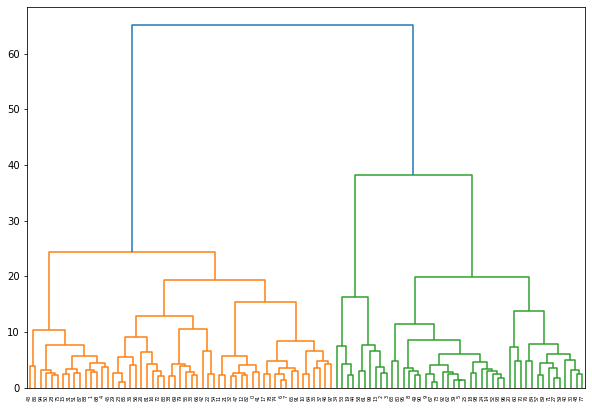

In [41]:
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

2. На том же датасете производим кластеризацию, используя любой другой метод кластеризации (пока с произвольными гиперпараметрами)

In [42]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [43]:
def getMetric(X, y, algo):
    metrics={
        'ARI': adjusted_rand_score(y, algo.labels_),
        'AMI': adjusted_mutual_info_score(y, algo.labels_),
        'Homogenity': homogeneity_score(y, algo.labels_),
        'Completeness': completeness_score(y, algo.labels_),
        'V-measure': v_measure_score(y, algo.labels_),
        'Silhouette': silhouette_score(X, algo.labels_)
    }
    return metrics

In [44]:
estimator = KMeans()

In [45]:
%%time
clusters = estimator.fit_predict(train)
np.unique(clusters, return_counts=True)

CPU times: user 4.19 s, sys: 278 ms, total: 4.46 s
Wall time: 337 ms


(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([1318,  806,  650, 1802,  406,  692,  780, 1417]))

In [46]:
getMetric(train, target, estimator)

{'ARI': 0.0658228267222421,
 'AMI': 0.09990837222464803,
 'Homogenity': 0.12231508651068802,
 'Completeness': 0.08546596795295214,
 'V-measure': 0.10062300714442038,
 'Silhouette': 0.38448682801632517}

 3. Оптимизация гиперпараметров KMeans (по гомогенности)

In [47]:
params = {
    'n_clusters': range(2, 9), 'tol': [0.0001, 0.001, 0.01]
}

In [48]:
grid = GridSearchCV(estimator=estimator, param_grid=params, scoring='v_measure_score', cv=5, n_jobs=-1)

In [49]:
%%time
grid.fit(train.values, target.values)

CPU times: user 2.69 s, sys: 136 ms, total: 2.83 s
Wall time: 2.18 s


GridSearchCV(cv=5, estimator=KMeans(), n_jobs=-1,
             param_grid={'n_clusters': range(2, 9),
                         'tol': [0.0001, 0.001, 0.01]},
             scoring='v_measure_score')

In [50]:
grid.best_params_

{'n_clusters': 6, 'tol': 0.001}

In [51]:
np.unique(grid.best_estimator_.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([1999, 1079, 1717, 1677,  907,  492]))

In [52]:
getMetric(train, target, grid.best_estimator_)

{'ARI': 0.07807780403533168,
 'AMI': 0.1045950763263282,
 'Homogenity': 0.11732389254841631,
 'Completeness': 0.0952619673550897,
 'V-measure': 0.10514814886552068,
 'Silhouette': 0.3733419732960149}

 4. Используя алгоритм/модель из п. 2 произвести оптимизацию гиперпараметра количества кластеров, используя "правило локтя" (анализируем график силуэта)

In [53]:
scores = []

for n_clusters in tqdm(range(2, 9)):
    clusters = KMeans(n_clusters=n_clusters, max_iter=450, tol=0.0001).fit_predict(train)
    scores.append(silhouette_score(train, clusters))

100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


Text(0, 0.5, 'silhouette score')

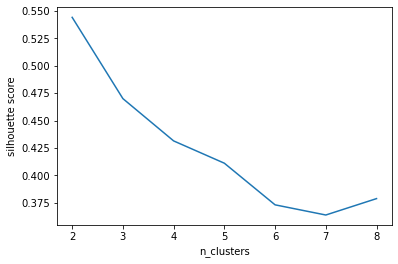

In [54]:
plt.plot(range(2, 9), scores)
plt.xlabel('n_clusters')
plt.ylabel('silhouette score')